#PARTE 0: IMPORTS

In [311]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,mean_squared_log_error,r2_score,make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler,Normalizer,FunctionTransformer,OneHotEncoder,OrdinalEncoder,MinMaxScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression,SGDRegressor,LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance

#PARTE 1

##1

In [385]:
df=pd.read_csv("dataset.csv")
df.head()

,Shape,Cut,Color,Clarity,Carat Weight,Length/Width Ratio,Depth %,Table %,Polish,Symmetry,Girdle,Culet,Length,Width,Height,Price,Type,Fluorescence
0,Cushion Modified,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,Medium to Thick,NaN,7.09,6.95,4.57,2640,GIA Lab-Grown,NaN
1,Pear,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,Medium to Thick,NaN,9.64,5.86,3.66,1070,GIA Lab-Grown,NaN
2,Oval,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,Medium to Thick,NaN,8.44,6.00,3.79,1070,GIA Lab-Grown,NaN
3,Heart,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,Slightly Thick to Very Thick,NaN,5.85,6.89,4.25,7110,GIA,Faint
4,Radiant,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,Thick,NaN,6.80,5.05,3.50,3050,GIA,NaN


In [386]:
print("il numero di istanze è: ",df.shape[0]," con ", df.shape[1], " attributi")

il numero di istanze è:  6485  con  18  attributi


In [387]:
df.isnull().sum()
#il dataset NON è completo. per ogni colonna ci sono questi valori nulli

,0
Shape,5
Cut,4303
Color,5
Clarity,5
Carat Weight,5
Length/Width Ratio,5
Depth %,7
Table %,17
Polish,20
Symmetry,20


In [388]:
#classe da predire = Type
df['Type'].value_counts()
#la classe GIA predomina i dataset con un rapporto circa del 50% da sola

,count
Type,
GIA,3355
IGI Lab-Grown,1876
GIA Lab-Grown,1254


##2

In [389]:
df['Volume']=df['Length']*df['Height']*df['Width']

Text(0, 0.5, 'price')

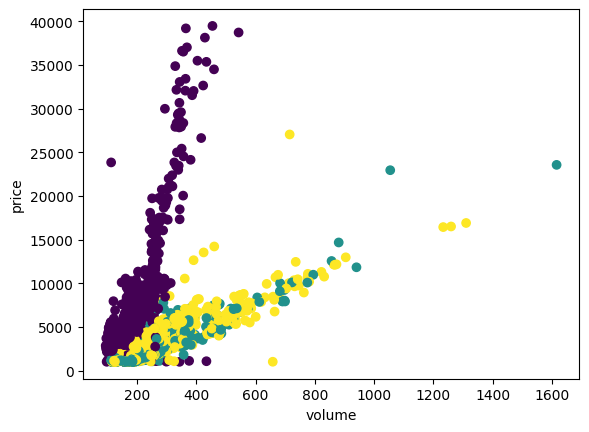

In [390]:
plt.scatter(df['Volume'],df['Price'],c=df['Type'].map({'GIA':0,'IGI Lab-Grown':1,'GIA Lab-Grown':2}))
plt.xlabel("volume")
plt.ylabel("price")
#vediamo che no, i diamanti più grandi non sono i più costosi, sebbene ci sia un trend di crescita
#aggiungo il colore per mostrare che il parametro principale
#solo all'interno di ogni categoria abbiamo il trend volume crescente => prezzo
#per farlo devo mappare categoria a numero

##3

In [391]:
df['Cut'].value_counts()

,count
Cut,
Ideal,1310
Excellent,606
Very Good,258
Astor,8


In [392]:
df['Carat Weight'].value_counts()

,count
Carat Weight,
1.00,1354
1.01,1256
1.02,420
1.03,293
1.04,219
...,...
5.06,1
7.11,1
2.38,1


In [393]:
pd.pivot_table(
    df,
    index=df['Cut'].dropna(), #considero i valori non nulli della colonna cut
    columns=pd.cut(df['Carat Weight'],bins=[0,1,2,3,4,5,6]), #discretizzo in 5 gruppi. non c'è niente sopra il 4,38 quindi li imposto a mano in modo da essere più preciso
    values='Price',
    aggfunc='mean'
)
#si nota che che all'aumentare dei carati il taglio diventa uno unico (probabilmente perchè)
#con le dimensioni diventa impossibile tagliare in maniera perfetta

<ipython-input-393-39113d4439f9>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pd.pivot_table(


Carat Weight,"(0, 1]","(1, 2]","(2, 3]","(3, 4]","(4, 5]"
Cut,,,,,
Astor,4140.000000,5521.428571,NaN,NaN,NaN
Excellent,3906.272727,2482.558140,NaN,NaN,NaN
Ideal,2819.902913,2343.100698,4844.114286,6897.857143,7680.0
Very Good,3534.809160,3220.157480,NaN,NaN,NaN


##4

<Axes: xlabel='Type', ylabel='Price per Carat'>

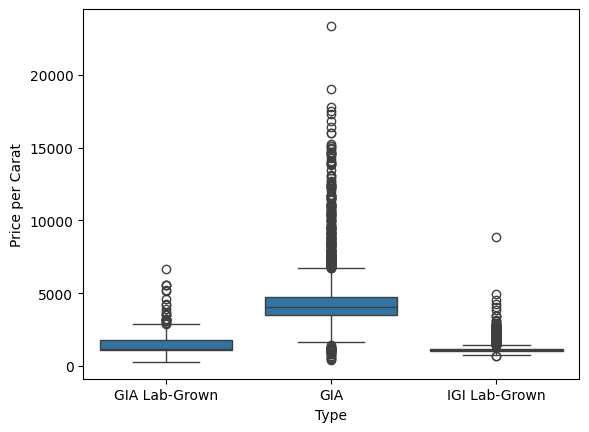

In [394]:
df['Price per Carat']=df['Price']/df['Carat Weight']
sns.boxplot(data=df,x=df['Type'],y=df['Price per Carat'])
#vediamo che i lab grown sono i più economici
#ma che ci sono molti valori fuori la distribuzione (tutti i pallini)

#PARTE 2

##1

In [395]:
#ricarico dataset
df=pd.read_csv("dataset.csv")
df.dropna(inplace=True,thresh=df.shape[0]/2,axis=1) #setto una soglia al 50% del numero di record.
#se ci sono più nulli viene droppata la colonna
#stessa cosa per le righe
df.dropna(inplace=True), #droppo tutte le righe con qualche valore nullo
#mi ha droppato 3 colonne

#TRASFORMO ISTANZE
#Type lo faccio con un map
df['Type']=df['Type'].map({'GIA':0,'IGI Lab-Grown':1,'GIA Lab-Grown':2})
# con ordinal encoder
df[['Girdle','Shape','Color','Clarity','Polish','Symmetry']]=OrdinalEncoder().fit_transform(df[['Girdle','Shape','Color','Clarity','Polish','Symmetry']])
#passate esplicitamente ma potevano essere selezionate col dtype


#SPLITTO
X,y=df.drop('Type',axis=1),df['Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=3/4, random_state=42,stratify=y)

#classificatori
dtc=DecisionTreeClassifier()
kn=KNeighborsClassifier()
dc=DummyClassifier()
#fit
dtc.fit(X_train,y_train)
kn.fit(X_train,y_train)
dc.fit(X_train,y_train)
#predict su train
y_dtc_t=dtc.predict(X_train)
y_kn_t=kn.predict(X_train)
y_dc_t=dc.predict(X_train)

#predict su test
y_dtc=dtc.predict(X_test)
y_kn=kn.predict(X_test)
y_dc=dc.predict(X_test)

#confronto accuracies train
#dai valori sotto vediamo che il tree impara benissimo il dataset
print("-----confronto accuracies su train-----")
print("accuracy tree: ",accuracy_score(y_train,y_dtc_t))
print("accuracy kn: ",accuracy_score(y_train,y_kn_t))
print("accuracy dummy: ",accuracy_score(y_train,y_dc_t))
print("------------------------------")
print("-----confronto accuracies su test-----")
print("accuracy tree: ",accuracy_score(y_test,y_dtc))
print("accuracy kn: ",accuracy_score(y_test,y_kn))
print("accuracy dummy: ",accuracy_score(y_test,y_dc))
#vediamo che l'albero comunque ha imparato bene il dataset mantenendo performance migliori del kn
#il quale va peggio sia in generalizzazione che apprendimento del dato

-----confronto accuracies su train-----
accuracy tree:  1.0
accuracy kn:  0.8609449143800288
accuracy dummy:  0.5176397771817619
------------------------------
-----confronto accuracies su test-----
accuracy tree:  0.9238861386138614
accuracy kn:  0.8199257425742574
accuracy dummy:  0.5179455445544554


In [396]:
#conf matric
print("cm tree: \n",confusion_matrix(y_train,y_dtc_t))
print("cm kn: \n",confusion_matrix(y_train,y_kn_t))
print("cm dummy: \n",confusion_matrix(y_train,y_dc_t))
#di nuovo, per l'albero tutto perfetto,
#il kneibours vediamo che compie errori ma sono comunque in minoranza rispetto alle classi dominanti
print("------------------------------")
print("-----confronto matrici su test-----")
print("cm tree: \n",confusion_matrix(y_test,y_dtc))
print("cm kn: \n",confusion_matrix(y_test,y_kn))
print("cm dummy: \n",confusion_matrix(y_test,y_dc))
#qui si vede che kneighbours si inizia a sbagliare sulla classe 2, i lab grown diamonds,
#guardando l'ultima riga si vede che l'ordine di grandezza degli errori è circa lo stesso del target

cm tree: 
 [[2509    0    0]
 [   0 1403    0]
 [   0    0  935]]
cm kn: 
 [[2452   24   33]
 [ 119 1187   97]
 [ 225  176  534]]
cm dummy: 
 [[2509    0    0]
 [1403    0    0]
 [ 935    0    0]]
------------------------------
-----confronto matrici su test-----
cm tree: 
 [[827   3   7]
 [  4 410  53]
 [  8  48 256]]
cm kn: 
 [[804  11  22]
 [ 44 384  39]
 [ 89  86 137]]
cm dummy: 
 [[837   0   0]
 [467   0   0]
 [312   0   0]]


In [397]:
print("f1 tree: \n",f1_score(y_train,y_dtc_t,average='weighted'))
print("f1 kn: \n",f1_score(y_train,y_kn_t,average='weighted'))
print("f1 dummy: \n",f1_score(y_train,y_dc_t,average='weighted'))
#albero perfetto, kneighbours impara molto bene, dummy ovviamente sbaglia molto
print("------------------------------")
print("-----confronto f1 su test-----")
print("f1 tree: \n",f1_score(y_test,y_dtc,average='weighted'))
print("f1 kn: \n",f1_score(y_test,y_kn,average='weighted'))
print("f1 dummy: \n",f1_score(y_test,y_dc,average='weighted'))
#si riconferma come prima con l'accuracy, l'albero si esprime bene in entrambe le classi
#anche il kn ma meno
#il dummy ovviamente tira a caso quindi ha recall e precision basse

f1 tree: 
 1.0
f1 kn: 
 0.8536531903900199
f1 dummy: 
 0.3531153346789126
------------------------------
-----confronto f1 su test-----
f1 tree: 
 0.9239068164060672
f1 kn: 
 0.8073213710128619
f1 dummy: 
 0.3534614111635379


##2

In [398]:
print("CROSS VALIDATION")
print("f1 tree: \n",cross_val_score(dtc,X,y,cv=10,scoring='f1_weighted').mean())
print("f1 kn: \n",cross_val_score(kn,X,y,cv=10,scoring='f1_weighted').mean())
print("f1 dummy: \n",cross_val_score(dc,X,y,cv=10,scoring='f1_weighted').mean())
#le performance rimangono costanti il che significa che i modelli lavorano bene

CROSS VALIDATION
f1 tree: 
 0.9295045881990077
f1 kn: 
 0.8087133168248798
f1 dummy: 
 0.35320206242655927


##3

In [399]:
importance=permutation_importance(kn,X,y,scoring='f1_weighted',n_repeats=5)

In [400]:
print(importance['importances_mean'])
#stampo le importanze medie
print("------------------------------")

pos=np.argsort(importance['importances_mean'],axis=None) #ordina crescente e ritorna gli indici
print(pos)
pos=pos[::-1]
#giro il vettore in modo da mettere per primi i più grandi
pos=pos[:2] #tengo solo i primi due
print(pos)
df.columns[pos]
#nota che essendo tutti e^ valore negativo è normale che 4.20748395e-01 (il 13)
#e 6.83060984e-02 (il 9) siano i pi+ grandi. sono comunque valori sotto 1

[ 6.28620537e-03  4.32082751e-03 -2.90367306e-05 -9.09227455e-05
 -5.46707644e-05  2.02204069e-02  1.37323129e-02  5.28533373e-04
  3.88066491e-03  6.86845337e-02  2.48842439e-03  3.38304388e-04
 -1.73907281e-05  4.21318505e-01]
------------------------------
[ 3  4  2 12 11  7 10  8  1  0  6  5  9 13]
[13  9]


Index(['Price', 'Girdle'], dtype='object')

##4

In [401]:
#cerco con gridsearch cv
params={
    "weights":['uniform','distance'],
    'n_neighbors':[3,5,10,15]
}
g=GridSearchCV(kn,params)
g.fit(X_train,y_train)
print(g.best_params_)
print("kn best accuracy train: ",accuracy_score(y_train,g.best_estimator_.predict(X_train)))
print("accuracy kn train: ",accuracy_score(y_train,y_kn_t)) #quella di prima
print("---------------------")
print("kn best accuracy test: ",accuracy_score(y_test,g.best_estimator_.predict(X_test)))
print("accuracy kn test: ",accuracy_score(y_test,y_kn)) #quella di prima
#vediamo che si migliora di pochissimo su test ma notevolmente su train

{'n_neighbors': 5, 'weights': 'distance'}
kn best accuracy train:  1.0
accuracy kn train:  0.8609449143800288
---------------------
kn best accuracy test:  0.8267326732673267
accuracy kn test:  0.8199257425742574


##5

In [402]:
#parto da X e y
#discretizzo length, width, height in 5 intervalli
#scalo price, gli altri nada
ct=ColumnTransformer(
    [
        ("discretizer",KBinsDiscretizer(n_bins=5),['Length',"Width","Height"]),
        ("scaler",MinMaxScaler(),['Price'])
    ],
    remainder='passthrough'
)
pipeline=Pipeline(
    [
        ("preprocessing",ct),
        ("estimator",KNeighborsClassifier(**g.best_params_))
    ]
)
pipeline.fit(X_train,y_train)
y_p_train=pipeline.predict(X_train)
y_p=pipeline.predict(X_test)
#passo il dizionario dei parametri migliori, potevo anche passare best estimator
print("accuracy kn train: ",accuracy_score(y_train,y_kn_t))
print("accuracy kn test: ",accuracy_score(y_test,y_kn))
print("-----------------")
print("accuracy pipeline train: ",accuracy_score(y_train,y_p_train))
print("accuracy pipeline test: ",accuracy_score(y_test,y_p))
print("---------------------")
print("best accuracy train: ",accuracy_score(y_train,g.best_estimator_.predict(X_train)))
print("best accuracy test: ",accuracy_score(y_test,g.best_estimator_.predict(X_test)))

#come vediamo migliorano entrambe le accuracies rispetto all'inizio

#rispetto al punto prima (best accuracy), il train si equivaglia ma addirittura la pipeline fa meglio

accuracy kn train:  0.8609449143800288
accuracy kn test:  0.8199257425742574
-----------------
accuracy pipeline train:  0.9997936868165875
accuracy pipeline test:  0.864480198019802
---------------------
best accuracy train:  1.0
best accuracy test:  0.8267326732673267


##6

In [403]:
#prendo il dataset coi valori droppati
#uso un encoder a piacere
#faccio simpleimputer
#standard scaler
#kneighbours


#ricarico dataset e droppo colonne
df=pd.read_csv("dataset.csv")
df.dropna(inplace=True,thresh=df.shape[0]/2,axis=1) #setto una soglia al 50% del numero di record.
#rimappo target dato che voglio lavorare con target numerico. inoltre mi permette di ignorarlo
#come colonna categorica nello step dopo
df['Type']=df['Type'].map({'GIA':0,'IGI Lab-Grown':1,'GIA Lab-Grown':2})

#estraggo solo le colonne categoriche
ccols=[]
for c,t in zip(df.columns,df.dtypes):
  if '64' not in str(t):
    ccols.append(c)

#separo in X e y
X,y=df.drop('Type',axis=1),df['Type']
#splitto di nuovo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=3/4, random_state=42,stratify=y)
#devo rifarlo perché prima la X era ripulita da tutti i valori mentre qui lo fa la pipeline

columntransf=ColumnTransformer(
    [
        ("encoder",OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),ccols)
        #gli dico di convertirmi a -1 i valori che non conosce se ne troverà nella predict
    ],remainder='passthrough',
    force_int_remainder_cols=False #metto per togliere il warning di sklearn
)
p=Pipeline(
    [
        ("ct",columntransf),
        ("simpleimputer",SimpleImputer(strategy='most_frequent')),
        ("scaler",StandardScaler()),
        ("estimator",KNeighborsClassifier())

    ]
)
p.fit(X_train,y_train)
#separo di nuovo in train e test

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Shape', 'Color', 'Clarity',
                                                   'Polish', 'Symmetry',
                                                   'Girdle'])])),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('estimator', KNeighborsClassifier())])

In [404]:
y_p_t=p.predict(X_train)
y_p=p.predict(X_test)
print("accuracy kn train: ",accuracy_score(y_train,y_p_t))
print("accuracy kn test: ",accuracy_score(y_test,y_p))
#performance decisamente migliorate
#abbiamo superato il 90% vs 85% di prima

accuracy kn train:  0.941805469874563
accuracy kn test:  0.9173859432799013


##7

In [332]:
new_p=Pipeline(
    [
        ("ct",columntransf),
        ("simpleimputer",SimpleImputer(strategy='most_frequent')),
        ("scaler",StandardScaler()),
        ("svd",TruncatedSVD()), #inserito un truncatedSVD
        ("estimator",KNeighborsClassifier())

    ]
)


#valuto i parametri migliori
param_grid={
    "svd__n_components":[2,4,6],
    "estimator__n_neighbors":[3,5,8],
    "estimator__weights":['uniform','distance']

}
gcv=GridSearchCV(new_p,param_grid)
gcv.fit(X_train,y_train)

y_pnew_t=gcv.best_estimator_.predict(X_train)
y_pnew=gcv.best_estimator_.predict(X_test)

print("accuracy best pipeline train: ",accuracy_score(y_train,y_pnew_t))
print("accuracy best pipeline test: ",accuracy_score(y_test,y_pnew))
gcv.best_params_
#le performance calano da 92 a 88 quindi vuol dire che le feature che vengono rimosse sono ancora importanti.
#dopotutto si passa da circa 15 a 6 features a causa di SVD. questo è possibile verificarlo aumentando
#il numero di componenti su cui fare gridsearch (si veda la cella sotto come paragone)

accuracy best pipeline train:  1.0
accuracy best pipeline test:  0.8859432799013564


{'estimator__n_neighbors': 5,
 'estimator__weights': 'distance',
 'svd__n_components': 6}

In [333]:
#per curiosità vedo che se metto 10 in svd vedo che accuracy migliora
#questo sicuramente è perché prima si tagliano troppe features dal dataset
param_grid={
    "svd__n_components":[4,6,10],
    "estimator__n_neighbors":[3,5,8],
    "estimator__weights":['uniform','distance']

}
gcv=GridSearchCV(new_p,param_grid)
gcv.fit(X_train,y_train)
y_pnew_t=gcv.best_estimator_.predict(X_train)
y_pnew=gcv.best_estimator_.predict(X_test)

print("accuracy best pipeline train: ",accuracy_score(y_train,y_pnew_t))
print("accuracy best pipeline test: ",accuracy_score(y_test,y_pnew))
gcv.best_params_

accuracy best pipeline train:  1.0
accuracy best pipeline test:  0.9186189889025894


{'estimator__n_neighbors': 3,
 'estimator__weights': 'distance',
 'svd__n_components': 10}